## 4\. Model Building

Now that we have the data ready, its time to start making predictive models. I will go through 5 scikit-learn simple models including linear regression, decision tree and random forest.

Since I’ll be making many models, instead of repeating the codes again and again, I would like to define a generic function which takes the algorithm and data as input and makes the model, performs cross-validation and generates submission.

I'll do the same thing later with H2O and XGboost

In [13]:
import pandas as pd
import numpy as np
import time
import csv
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import math

_start_time = time.time()

def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [28]:
#   rmsle - error function used in LB
def rmsle_func(actual, predicted):
    return np.sqrt(msle(actual, predicted))
def msle(actual, predicted):
    return np.mean(sle(actual, predicted))
def sle(actual, predicted):
    return (np.power(np.log(np.array(actual)+1) -  np.log(np.maximum(0,np.array(predicted))+1), 2))

def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(max(0,y_pred[i]) + 1) - math.log(max(0,y[i]) + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5


from sklearn import cross_validation, metrics

def modelfit(alg, dtrain, dval, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    y = alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    
    #Predict validation (holdout) set:
    dval_predictions = alg.predict(dval[predictors])

    #Perform cross-validation:
    #cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=2, scoring='mean_squared_error')
    #cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print ("\nModel Report")
    #print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    #print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
      
    print ('RMSLE TRAIN: ', rmsle_func(dtrain[target].values, dtrain_predictions))
    print ('RMSLE VAL: ', rmsle_func(dval[target].values, dval_predictions))
    #print ('rmsle: ', rmsle(dtrain[target].values, dtrain_predictions))
    print ('RMSE TRAIN', np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print ('RMSE VAL', np.sqrt(metrics.mean_squared_error(dval[target].values, dval_predictions)))
        
      
        
    #Predict on testing data: we need to revert it back to target by applying expm1
    dtest[target] = np.expm1(alg.predict(dtest[predictors]))
    
    
    #Export submission file:
    #IDcol.append(target)
    #submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission = dtest[[IDcol,target]].copy()
    submission[IDcol] = submission[IDcol].astype(int)
    submission.rename(columns={target: 'Demanda_uni_equil'}, inplace=True)
    submission.to_csv("./Submissions/"+filename, index=False)
    

In [16]:
#now we load our modified train and test set

tic()
#train = pd.read_csv('./input-data/train_modified.csv', nrows = 500000)
#test = pd.read_csv('./input-data/test_modified.csv', nrows = 500000)
train = pd.read_csv('./input-data/train_modified.csv',
                    dtype = {'Semana': 'int8',
                            'Agencia_ID': 'uint16',
                            'Canal_ID': 'int8',
                            'Ruta_SAK': 'int32',
                            'Cliente_ID': 'int32',
                            'Producto_ID': 'int32',
                            'log_target':  'float64',
                            'Log_Target_mean_lag1': 'float64',
                            'Log_Target_mean_lag2': 'float64',
                            'Log_Target_mean_lag3': 'float64',
                            'Log_Target_mean_lag4': 'float64',
                            'Lags_sum': 'float64',
                            'pairs_mean':  'float64',
                            'brand': 'uint16',
                            'cluster': 'uint16',
                            'Qty_Ruta_SAK_Bin': 'int8',
                            'ZipCode': 'uint16'},
                   )

                    
test = pd.read_csv('./input-data/test_modified.csv',
                    dtype = {'id': 'uint32',
                            'Semana': 'int8',
                            'Agencia_ID': 'uint16',
                            'Canal_ID': 'int8',
                            'Ruta_SAK': 'int32',
                            'Cliente_ID': 'int32',
                            'Producto_ID': 'int32',
                            'Log_Target_mean_lag1': 'float64',
                            'Log_Target_mean_lag2': 'float64',
                            'Log_Target_mean_lag3': 'float64',
                            'Log_Target_mean_lag4': 'float64',
                            'Lags_sum': 'float64',
                            'pairs_mean': 'float64',
                            'brand': 'uint16',
                            'cluster': 'uint16',
                            'Qty_Ruta_SAK_Bin': 'int8',
                            'ZipCode': 'uint16'},
                      )
tac()

Time passed: 0hour:1min:32sec


In [17]:
# We split the train set to get a validation set
tic()
val = train[train.Semana > 8] # Weeks 9
train = train[train.Semana <=8] # Weeks 7,8
tac()

Time passed: 0hour:0min:3sec


In [18]:
test.head()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,log_target,Log_Target_mean_lag1,Log_Target_mean_lag2,Log_Target_mean_lag3,Log_Target_mean_lag4,Lags_sum,pairs_mean,brand,cluster,Qty_Ruta_SAK_Bin,ZipCode
0,924190,11,1110,7,3301,15766,1216,NaN,0.000000,0.000000,1.791759,1.098612,2.890372,1.279644,1,2,1,2008
1,4521987,11,1110,7,3301,15766,1240,NaN,0.000000,1.098612,1.098612,2.197225,4.394449,1.616666,1,14,1,2008
2,6217476,10,1110,7,3301,15766,1242,NaN,0.693147,0.693147,1.098612,1.386294,3.871201,1.106057,1,25,1,2008
3,970784,10,1110,7,3301,15766,3894,NaN,2.639057,1.098612,1.609438,1.609438,6.956545,1.882732,13,18,1,2008
4,3448837,11,1110,7,3301,15766,30531,NaN,0.000000,2.890372,2.890372,2.639057,8.419801,2.503683,13,12,1,2008


Let's define now the target and the Id cols

In [19]:
#Define target and ID columns:
target = 'log_target'
IDcol = 'id'

### Alg1 - Linear Regression Model

Lets make our first linear-regression model


Model Report
RMSLE TRAIN:  0.137664614945
RMSLE VAL:  0.13480094318
RMSE TRAIN 0.329705789178
RMSE VAL 0.320297658136
Time passed: 0hour:1min:3sec


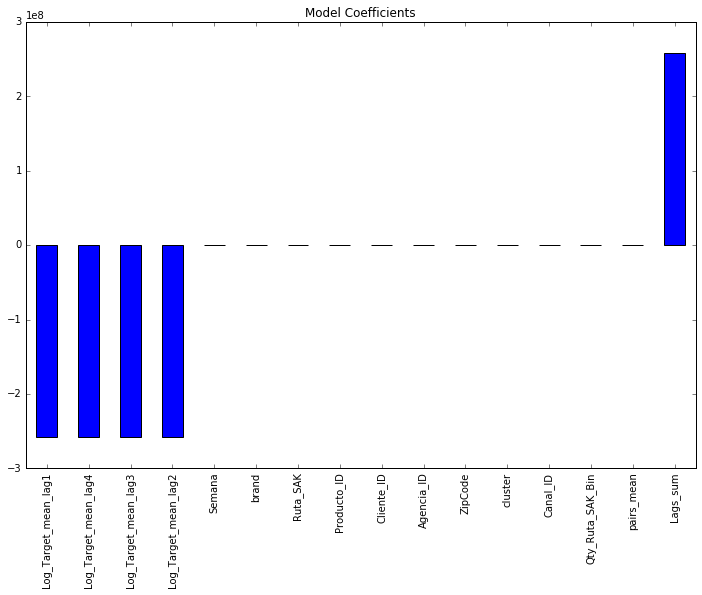

In [29]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
predictors = [x for x in train.columns if x not in [target]+[IDcol]]
# print predictors
alg1 = LinearRegression(normalize=True)
tic()
modelfit(alg1, train, val, test, predictors, target, IDcol, 'alg1.csv')
tac()
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')

## --> LB: 0.50568

We can see this is better than baseline model. But if you notice the coefficients, they are very large in magnitude which signifies overfitting. To cater to this, lets use a ridge regression model.

### Alg2 - Ridge Regression Model:


Model Report
RMSLE TRAIN:  0.140281142123
RMSLE VAL:  0.137140728663
RMSE TRAIN 0.334302059026
RMSE VAL 0.324636735861
Time passed: 0hour:0min:54sec


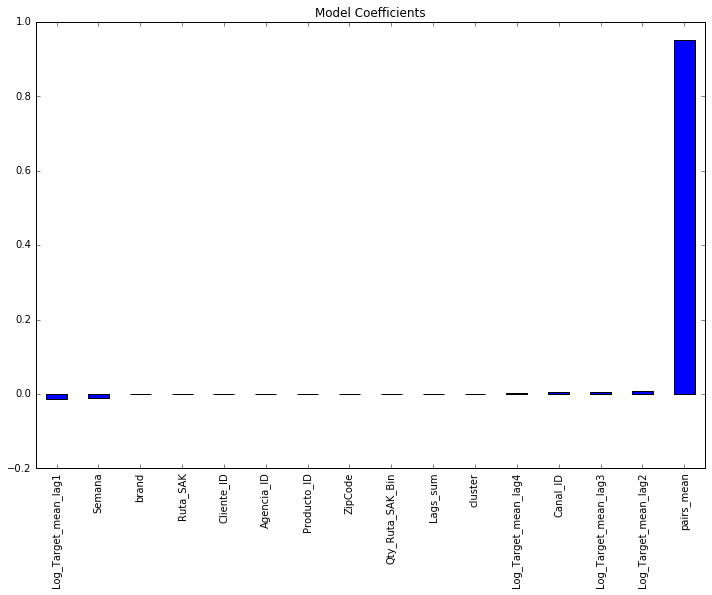

In [30]:
predictors = [x for x in train.columns if x not in [target]+[IDcol]]
alg2 = Ridge(alpha=0.05,normalize=True)
tic()
modelfit(alg2, train, val, test, predictors, target, IDcol, 'alg2.csv')
tac()
coef2 = pd.Series(alg2.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')

Though the regression coefficient look better now, the score is about the same (or worst). We can tune the parameters of the model for slightly better results but I don’t think there will be a significant improvement.

### Alg3 - Decision Tree Model

Lets try out a decision tree model and see if we get something better.


Model Report
RMSLE TRAIN:  0.116534850906
RMSLE VAL:  0.11380807391
RMSE TRAIN 0.285645807055
RMSE VAL 0.273418255774
Time passed: 0hour:6min:56sec


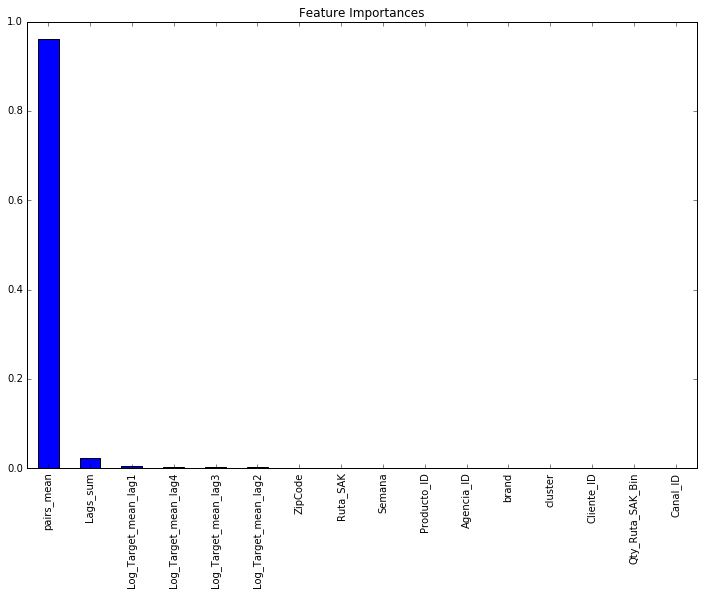

In [31]:
from sklearn.tree import DecisionTreeRegressor
predictors = [x for x in train.columns if x not in [target]+[IDcol]]
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
tic()
modelfit(alg3, train, val, test, predictors, target, IDcol, 'alg3.csv')
tac()
coef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')

### Alg4 - Decision Tree Model v2

Lets try making a decision tree with just 7 variables, a max_depth of 25 and min_samples_leaf as 150.


Model Report
RMSLE TRAIN:  0.211744650896
RMSLE VAL:  0.216217978507
RMSE TRAIN 0.503859816036
RMSE VAL 0.517297711189
Time passed: 0hour:3min:12sec


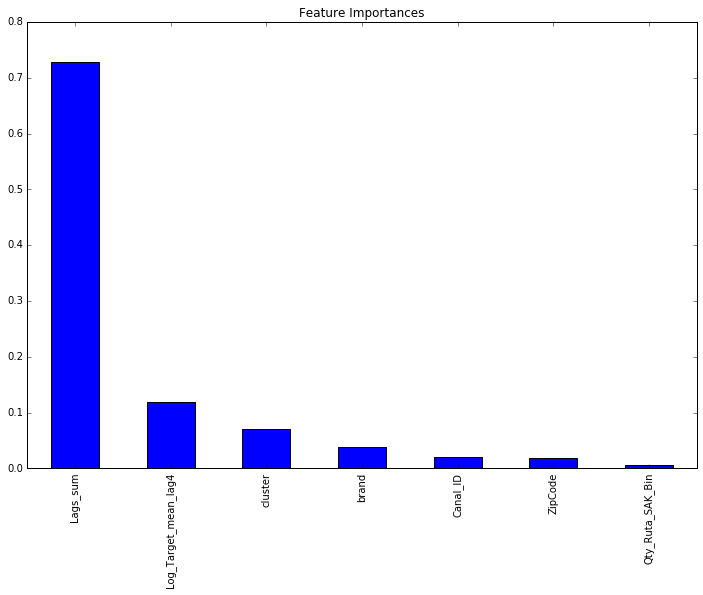

In [32]:
predictors = ['Log_Target_mean_lag4','Lags_sum','Qty_Ruta_SAK_Bin','cluster','brand','ZipCode','Canal_ID']
alg4 = DecisionTreeRegressor(max_depth=25, min_samples_leaf=150)
tic()
modelfit(alg4, train, val, test, predictors, target, IDcol, 'alg4.csv')
tac()
coef4 = pd.Series(alg4.feature_importances_, predictors).sort_values(ascending=False)
coef4.plot(kind='bar', title='Feature Importances')

## --> LB: 0.51100

We can fine tune the model further using other parameters. But let's try now a Random Forest to see if we get some improvement

### Alg5 - Random Forest Model


Model Report
RMSLE TRAIN:  0.211811979117
RMSLE VAL:  0.21556797908
RMSE TRAIN 0.503831899291
RMSE VAL 0.515069996477
Time passed: 0hour:8min:53sec


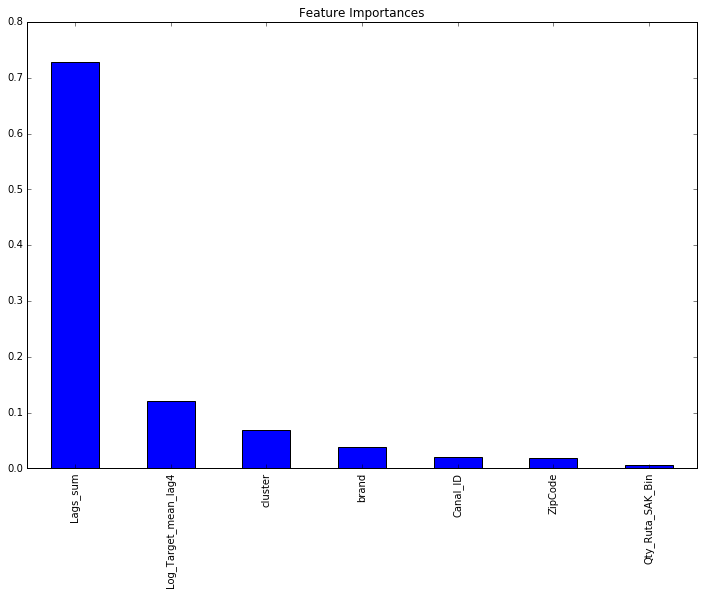

In [33]:
from sklearn.ensemble import RandomForestRegressor
predictors = ['Log_Target_mean_lag4','Lags_sum','Qty_Ruta_SAK_Bin','cluster','brand','ZipCode','Canal_ID']
alg5 = RandomForestRegressor(n_estimators=20,max_depth=25, min_samples_leaf=150,n_jobs=-1)
tic()
modelfit(alg5, train, val, test, predictors, target, IDcol, 'alg5.csv')
tac()
coef5 = pd.Series(alg5.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')

Better than the tree as expected